In [2]:
from scipy import stats
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
import pandas as pd
import numpy as np
from theano import shared
from sklearn import preprocessing

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.6


# Statistics

Statistics is about collecting, organizing, analyzing, and interpreting data, and hence statistical knowledge is essential for data analysis. Two main methods:
* Exploratory Data Analysis (EDA): This is about numerical summaries, such as the mean, mode, standard deviation, and interquartile ranges (this part of EDA is also know as descriptive statistics). EDA is also about visually inspecting the data, using tools you may be already familiar with, such as histograms and scatter plots.
* Inferential statistics: This is about making statements beyond the current data. We may want to understand some particular phenomenon, or maybe we want to make predictions for future (as yet unobserved) data points, or we need to choose among several competing explanations for the same observations. Inferential statistics is the set of methods and tools that will help us to answer these types of questions

## Bayesian Modeling

Models are simplified descriptions of a given system or process that, for some reason, we are interested in. Those descriptions are deliberately designed to capture only the most relevant aspects of the system and not to explain every minor detail. This is one reason a more complex model is not always a better one.

In summary the Bayesian modeling process uses three steps:
1. Given some data and some assumptions on how this data could have been generated, we design a model by combining building blocks known as probability distributions. Most of the time these models are crude approximations, but most of the time is all we need.
2. We use Bayes' theorem to add data to our models and derive the logical consequences of combining the data and our assumptions. We say we are conditioning the model on our data.
3. We criticize the model by checking whether the model makes sense according to different criteria, including the data, our expertise on the subject, and sometimes by comparing several models.

Bayesian models are also known as probabilistic models because they are built using probabilities. Why probabilities? Because probabilities are the correct mathematical tool to model uncertainty

## Baye's Theorem

$$p(\theta | y) = \frac{p(y | \theta)p(\theta)}{p(y)}$$

First, this says that $p(\theta | y)$ is not necessarily the same as $p(y|\theta)$
* The probability of a person being the Pope given that this person is Argentinian is not the same as the probability of being Argentinian given that this person is the Pope.

If we replace $\theta$ with _hypothesis_ and $y$ with _data_, Bayes' theorem tells us how to compute the probability of a hypothesis, $\theta$, given the data, $y$.


How do we turn a hypothesis into something we can plug into Bayes' Theorem? **Usiing probability distributions**

## Parts of Baye's Theorem

* $p(\theta)$: Prior
* $p(y | \theta)$: Likelihood
* $p(\theta | y)$: Posterior
* $p(y)$: Marginal Likelihood

The **prior distribution** should reflect what we know about the value of the $\theta$ parameter before seeing the data, $y$. If we know nothing, like Jon Snow, we could use flat priors that do not convey too much information.

The **likelihood** is how we will introduce data in our analysis. It is an expression of the plausibility of the data given the parameters.

The **posterior distribution** is the result of the Bayesian analysis and reflects all that we know about a problem (given our data and model). The posterior is a probability distribution for the $\theta$ parameters in our model and not a single value. 

Think of the posterior as the updated prior in the light of (new) data. The posterior from one analysis can be used as the prior for a new analysis. This makes Bayesian analysis useful for analyzing data that becomes available in sequential order.

The **Marginal likelihood** also known as **evidence** has a formal definition but for practical purposes it's just used as a normalization factor. 

## Is a coin fair?

The coin-flipping problem, is a classical problem in statistics and goes like this: we toss a coin a number of times and record how many heads and tails we get. Based on this data, we try to answer questions such as, is the coin fair? Or, more generally, how biased is the coin?

For this example, we will assume that we have already tossed a coin a number of times and we have a record of the number of observed heads, so the data-gathering part is already done.

We will say that a coin with a bias of 1 will always land heads, one with a bias of 0 will always land tails, and one with a bias of 0.5 will land half of the time heads and half of the time tails. To represent the bias, we will use the $\theta$ parameter, and to represent the total number of heads for a $N$ number of tosses, we will use the $y$ variable.

We now have to define our prior, $p(\theta)$ and likelihood $p(y | \theta)$.

## Likelihood

* We know only two outcomes are possible, heads or tails.
* We also know that a coin toss does not affect other tosses (aka they're independent)

This seems like a good fit for a **binomial distribution**
* This is a discrete distribution returning the probability of getting $y$ heads (successes) out of $N$ coin tosses (trials or experiments) given a fixed value of $\theta$

## Posterior

As a posterior we will use a **beta distribution** which is very common in bayesian stats.

Reasons:
* The beta distribution is very flexible and can take many shapes.
* It is restricted between 0 and 1, in the same way our $\theta$ parameter is.
* It is used very often when we want to model proportions for a binomial variable.

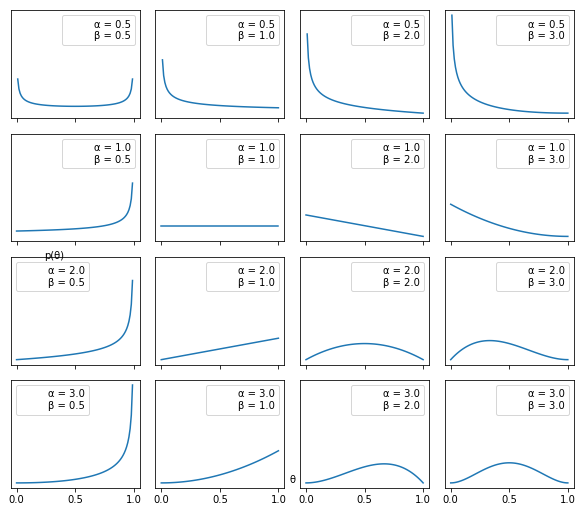

In [3]:
params = [0.5, 1, 2, 3]
x = np.linspace(0, 1, 100)
f, ax = plt.subplots(len(params), len(params), sharex=True, sharey=True,
                     figsize=(8, 7), constrained_layout=True)
for i in range(4):
    for j in range(4):
        a = params[i]
        b = params[j]
        y = stats.beta(a, b).pdf(x)
        ax[i,j].plot(x, y)
        ax[i,j].plot(0, 0, label="α = {:2.1f}\nβ = {:2.1f}".format(a, b), alpha=0)
        ax[i,j].legend()
ax[1,0].set_yticks([])
ax[1,0].set_xticks([0, 0.5, 1])
f.text(0.5, 0.05, 'θ', ha='center')
f.text(0.07, 0.5, 'p(θ)', va='center', rotation=0)
plt.savefig('B11197_01_04.png', dpi=300)

## Model Notation and visualization

$$\theta \sim{Beta(\alpha, \beta})$$

$$y \sim{Bin(n=1, p=\theta})$$

* The $\theta$ parameter is distributed as a beta distribution with $\alpha$ and $\beta$ parameters.
& $y$ is distributed as a binomial with $n=1$ and $p=\theta$ parameters.

The same can be represented graphically using Krushcke's diagrams:

 <img src="B11197_01_06.png" width="500">

In [5]:
np.random.seed(123)
trials = 4
theta_real = 0.35 #unkown value in a real experiment
data = stats.bernoulli.rvs(p=theta_real, size=trials)
data


with pm.Model() as coin_flip_model:
    # a priori
    θ = pm.Beta('θ', alpha=1.0, beta=1.0)
    # likelihood
    y = pm.Bernoulli('y', p=θ, observed=data)
    trace = pm.sample(1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:00<00:00, 7853.04draws/s]
The acceptance probability does not match the target. It is 0.8832139313883836, but should be close to 0.8. Try to increase the number of tuning steps.


/Users/franco/miniconda3/envs/bap/lib/python3.6/site-packages/arviz/data/io_pymc3.py:78: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  log_likelihood, dims = self._extract_log_likelihood()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x133e97208>,
      dtype=object)

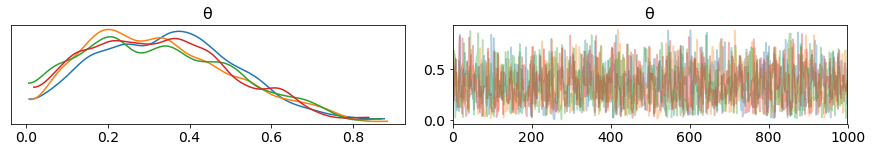

In [7]:
az.plot_trace(trace)

In [8]:
az.summary(trace)

/Users/franco/miniconda3/envs/bap/lib/python3.6/site-packages/arviz/data/io_pymc3.py:78: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  log_likelihood, dims = self._extract_log_likelihood()


,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
θ,0.33,0.18,0.0,0.04,0.66,1720.0,1.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1339fbe10>],
      dtype=object)

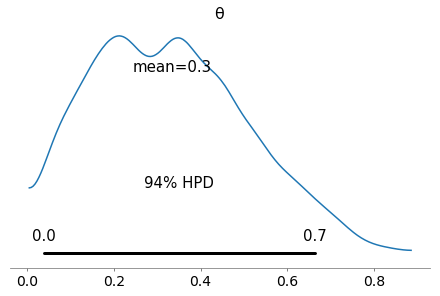

In [9]:
az.plot_posterior(trace)

## Highest-posterior density

A commonly-used device to summarize the spread of a posterior distribution is to use a Highest-Posterior Density (HPD) interval.

If we say that the 95% HPD for some analysis is [2-5], we mean that according to our data and model, we think the parameter in question is between 2 and 5 with a probability of 0.95.

<img src="B11197_01_08.png" width="500">